In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import math
import re

from nilearn import datasets, plotting
from nilearn import maskers, image
import matplotlib.pyplot as plt
import nibabel

Function to extract the path of files with specific name structure.

In [ ]:
def get_file_path(main_directory,file_name):
    """
    Get the path of files for different subjects.
    
    Args:
    -----
      *main_directory* : string
        location of the main directory having all the subjects.
      *file_name* : string
        end of the file name which you are looking for including the file type
    Returns:
    --------
      *file_path* : dictionary
        dictionary with keys as subject_numbers and values as respective file path.
    """
    

    # Get a list of subject directories that start with "sub-"
    subject_directories = sorted([d for d in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, d)) and d.startswith("sub-")])

    # Initialize lists to store data
    fmri_path = []
    file_path = {}

    # Loop through subject directories
    for subject_dir in subject_directories:
        fmri_path = []
        subject_path = os.path.join(main_directory, subject_dir)
        func_dir = os.path.join(subject_path, "func")

        if os.path.exists(func_dir) and os.path.isdir(func_dir):
            # Assuming fMRI files have a common pattern, such as '*.nii.gz' inside the "func" subdirectory
            fmri_files = [f for f in os.listdir(func_dir) if f.endswith(file_name)]

            # Loop through fMRI files
            for fmri_file in fmri_files:
                fmri_path.append(os.path.join(func_dir, fmri_file))
            file_path[subject_dir]= sorted(np.array(fmri_path))

    return(file_path)

Code to extract the run number from the file name

In [ ]:
def extract_task_run_from_filename(filename):
    pattern = r'task-(rest|sleep)_run-\d+'
    match = re.search(pattern, filename)
    return match.group() if match else None

Code to extract time series from specific ROIs based on the literature

In [ ]:
from nilearn.input_data import NiftiSpheresMasker
import pandas as pd
import numpy as np


def get_roi_time_series(fmri_path,atlas_dir,window_size_seconds=30,display_report=False):

    # Array of region names
    roi_names = [
        "Cuneus", "Middle occipital gyrus", "Middle occipital gyrus", 
        "Dorsal anterior cingulate", "Superior temporal gyrus", "Superior temporal gyrus",
        "Superior temporal gyrus", "Superior temporal gyrus", "Supplementary motor area", 
        "Postcentral gyrus", "Postcentral gyrus", "ORBmid", 
        "Precuneus", "Angulargyrus", "Angulargyrus", 
        "Middle frontal gyrus", "Middle frontal gyrus", "Precuneus", 
        "Supramarginal gyrus", "Supramarginal gyrus", "Thalamus", "Thalamus"
    ]

    # Array of roi coordinates
    roi_coords = [
        (2, -82, 20), (30, -90, 16), (-26, -90, 16),
        (2, 6, 44), (8, -2, -4), (-54, -2, -8),
        (62, -22, 16), (-58, -22, 8), (-2, -14, 48),
        (50, -14, 52), (-38, -14, 52), (2, 54, -8),
        (2, -62, 44), (50, -66, 28), (-46, -70, 28),
        (34, 46, 20), (-34, 42, 20), (10, -42, 48),
        (58, -38, 28), (-58, -42, 28), (8, -18, 8), (-8, -18, 8)
    ]

    n_regions = len(roi_names)

    # Adjust the radius as per your requirement
    masker = NiftiSpheresMasker(
        seeds=roi_coords,
        radius=8,
        detrend=True,
        standardize=True,
        low_pass=None,
        high_pass=None,
        t_r=None,
        memory='nilearn_cache',
        memory_level=1,
        verbose=0
    )

    time_series = masker.fit_transform(fmri_path)

    # Display report if needed
    if display_report:
        print("Dimension of the fMRI signal (x,y,z,timestamps): ", nibabel.load(fmri_path).shape)
        print("Dimension of the combined time series (timestamps, voxels): ", time_series.shape)
        print(f'Combined atlas has {n_regions} ROIs.')
        print(roi_names)

    window_size = int(window_size_seconds / 2.1)  # The normal window size
    first_window_correction = 5  # TRs to remove for the first epoch

    # Adjusted to account for the shortened first window
    adjusted_length = len(time_series[:, 0]) - first_window_correction
    num_windows = 2 + ((adjusted_length - window_size) // window_size)
    n_regions = time_series.shape[1]
    region_ts = np.empty((num_windows, n_regions), dtype=object)
    region_index = 0

    for region in zip(*time_series):
        # Special handling for the first window
        start_idx = 0
        end_idx = window_size - first_window_correction
        region_ts[0, region_index] = region[start_idx:end_idx]

        # Process subsequent windows
        for i in range(1, num_windows):
            start_idx = (i * window_size) - first_window_correction
            end_idx = start_idx + window_size
            region_ts[i, region_index] = region[start_idx:end_idx]

        region_index += 1

    # Construct DataFrame with appropriate column names
    columns = [f'{label}' for i, label in enumerate(roi_names, start=1)]
    region_ts_df = pd.DataFrame(region_ts, columns=columns)
    return region_ts_df


atlas_dir = "../python_scripts/resources/atlas"
fmri_files = get_file_path("../output_directory", "postproc_smooth.nii.gz")
# selected_keys = ['sub-02']
# # # Creating a new dictionary with only the selected keys
# fmri_files = {key: fmri_files[key] for key in selected_keys}

roi_ts_dfs = []
for subject, fmri_file in fmri_files.items():
        for file_path in fmri_file:
          region_ts_df = get_roi_time_series(file_path, atlas_dir,window_size_seconds=30,display_report=False)
          region_ts_df.insert(0, 'run', extract_task_run_from_filename(os.path.basename(file_path)))
          region_ts_df.insert(0, 'subject', subject)
          roi_ts_dfs.append(region_ts_df)
          print(f"{extract_task_run_from_filename(os.path.basename(file_path))} of {subject} successfully completed")

result_df = pd.concat(roi_ts_dfs, ignore_index=True)

result_df.to_csv('../output_directory/evaluation_dataset/roi_dataset/roi_dataset_corrected.csv', index=False, header=True)


Script to get the ROI Evaluation Dataset with all the following information:
    - Grouped Subject having same name, run and consecutive sleep stages
    - Total datapoints representing the number of epochs

In [ ]:
def read_csv(file_path):
    return pd.read_csv(file_path)

# Reading the uploaded CSV file
df = read_csv('../output_directory/evaluation_dataset/roi_dataset/roi_dataset.csv')

def process_data(df):
    # Renaming columns for clarity
    df.columns.values[0:3] = ['subject', 'run', 'sleep_stage']

    # Identify consecutive series and assign group IDs
    consecutive_series = (df['subject'] != df['subject'].shift(1)) | \
                         (df['run'] != df['run'].shift(1)) | \
                         (df['sleep_stage'] != df['sleep_stage'].shift(1))
    group_id = consecutive_series.cumsum()
    
    # Group by 'subject', 'run', 'sleep_stage', and group_id
    grouped = df.groupby([df.columns[0], df.columns[1], df.columns[2], group_id],sort=False)
    
    aggregation = {col: lambda x: list(x) for col in df.columns[3:]}
    processed_data = grouped.agg(aggregation).reset_index()

    processed_data.insert(4, 'Total datapoints', processed_data.iloc[:,4].apply(lambda x: len(x)))
    # processed_data['Total datapoints'] = processed_data.apply(lambda row: 9 + (len(row.iloc[4]) - 1) * 14, axis=1)
    processed_data = processed_data.drop('level_3', axis=1)
    return processed_data

processed_df = process_data(df)

def write_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

output_file_path = '../output_directory/evaluation_dataset/roi_dataset/roi_eval_dataset.csv'
write_to_csv(processed_df, output_file_path)

PSD Slope Implementation:
    - New metrics which calculates the slope of the PSD graph for each sleep score.

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

def get_spectral_features(time_series,normalize):

    time_series = np.array(time_series)
    window_length = 104  # in seconds
    window_length_volumes = int(window_length / 2.1)
    low_freq_band=(0, 0.1)
    high_freq_band=(0.1, 0.25)

    frequencies, _, psd = spectrogram(time_series, fs=1 / 2.1, window='hamming', nperseg=window_length_volumes)
    
    psd = np.mean(psd,axis=1)

    peak_idx = np.argmax(psd)
    peak_freq = frequencies[peak_idx]
    peak_power = psd[peak_idx]
    
    # Calculate the Spectral Entropy
    psd_normalized = psd / np.sum(psd)  # Normalize the PSD

    def band_entropy(freqs, psd_normalized, band):
        band_mask = (freqs >= band[0]) & (freqs <= band[1])
        band_psd = psd_normalized[band_mask]
        band_psd += np.finfo(float).eps
        entropy = -np.sum(band_psd * np.log2(band_psd))
        return entropy
    
    low_freq_entropy = band_entropy(frequencies, psd_normalized, low_freq_band)
    high_freq_entropy = band_entropy(frequencies, psd_normalized, high_freq_band)

    spectral_entropy_lvh = low_freq_entropy - high_freq_entropy
    
    if normalize:
        spectral_entropy_lvh /= np.log2(len(psd))
    

    return frequencies, psd , peak_freq, peak_power,spectral_entropy_lvh

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def compute_connectivity(data, plot=True):
    # Calculate the Pearson correlation matrix
    connectivity_matrix = np.corrcoef(data)
    
    # Get the upper triangle of the correlation matrix
    upper_triangle = np.triu(connectivity_matrix, k=1)
    
    if plot:
        # Plot the connectivity matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(upper_triangle, cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Correlation')
        plt.title('Connectivity Matrix')
        plt.xlabel('Regions')
        plt.ylabel('Regions')
        plt.show()
    
    return upper_triangle


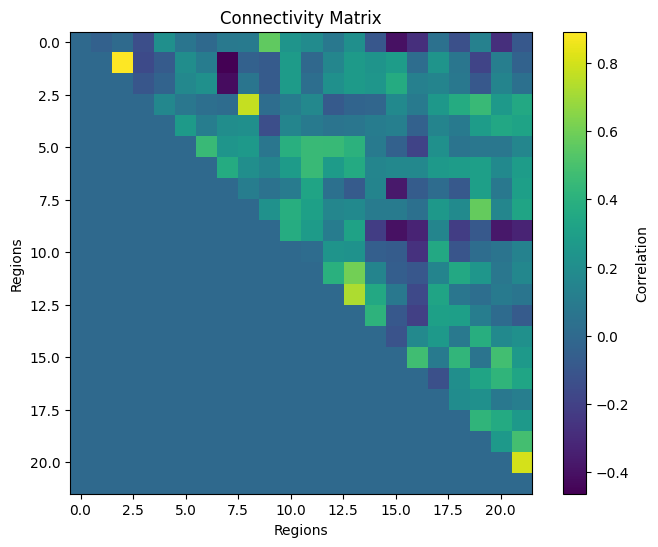

[[ 0.   -0.04  0.   -0.14  0.21  0.06  0.    0.08  0.09  0.56  0.24  0.19  0.08  0.21 -0.09 -0.4  -0.28  0.04 -0.14  0.13 -0.28 -0.09]
 [ 0.    0.    0.89 -0.16 -0.07  0.2   0.11 -0.46 -0.04 -0.08  0.28 -0.    0.16  0.27  0.24  0.28  0.02  0.24  0.07 -0.19  0.12 -0.04]
 [ 0.    0.    0.   -0.1  -0.03  0.17  0.22 -0.42  0.06 -0.08  0.28  0.03  0.22  0.27  0.25  0.37  0.13  0.15  0.08 -0.09  0.15  0.04]
 [ 0.    0.    0.    0.    0.17  0.07  0.03  0.02  0.77  0.02  0.1   0.17 -0.08 -0.03 -0.02  0.18  0.09  0.26  0.37  0.46  0.27  0.36]
 [ 0.    0.    0.    0.    0.    0.28  0.11  0.2   0.21 -0.14  0.15  0.1   0.06  0.07  0.1   0.12 -0.04  0.15  0.09  0.28  0.35  0.32]
 [ 0.    0.    0.    0.    0.    0.    0.45  0.24  0.27  0.07  0.39  0.46  0.45  0.41  0.09 -0.04 -0.19  0.22  0.06  0.08  0.07  0.16]
 [ 0.    0.    0.    0.    0.    0.    0.    0.37  0.2   0.15  0.28  0.46  0.28  0.37  0.15  0.17  0.17  0.26  0.29  0.3   0.18  0.29]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.11

In [82]:
import pandas as pd
import re

def read_csv(file_path):
    return pd.read_csv(file_path)

# Convert string representation of list of tuples to a list of floats
def convert_string_to_list(data_string):
    data_string = data_string[1:-1]
    tuples = re.findall(r'\((.*?)\)', data_string)
    list_of_floats = [float(num) for t in tuples for num in t.split(', ')]
    return list_of_floats

# Reading the uploaded CSV file
df = read_csv('../output_directory/evaluation_dataset/roi_dataset/roi_eval_dataset.csv')

peak_freq = {}
region_columns = df.columns[4:]

# Calculate correlation of each region per row
correlation_values = {}

for region in region_columns:
    df[region] = df.apply(lambda row: convert_string_to_list(row[region]), axis=1).values

# df[region_columns].iloc[[0]].head()
corr_matrix = compute_connectivity(df[region_columns].iloc[0].apply(pd.Series))

np.set_printoptions(precision=2, linewidth=150)
print(corr_matrix)

#     df[region] = df.apply(lambda row: get_spectral_features(convert_string_to_list(row[region]),False)[4], axis=1)
#     print(f"{region} completed")

# state_list= df["run"].apply(lambda x: 'rest' if 'rest' in x else 'sleep')
# df.insert(2, 'state', state_list)
# df['sleep_stage'] = df['sleep_stage'].apply(lambda x: "W" if (x.split()[0] == 'W') else x.split()[0])

# # Save the updated DataFrame to a new CSV file
# df.to_csv('../output_directory/evaluation_dataset/spectral_evaluation/spectral_dataset_ho.csv', index=False)

Box plots

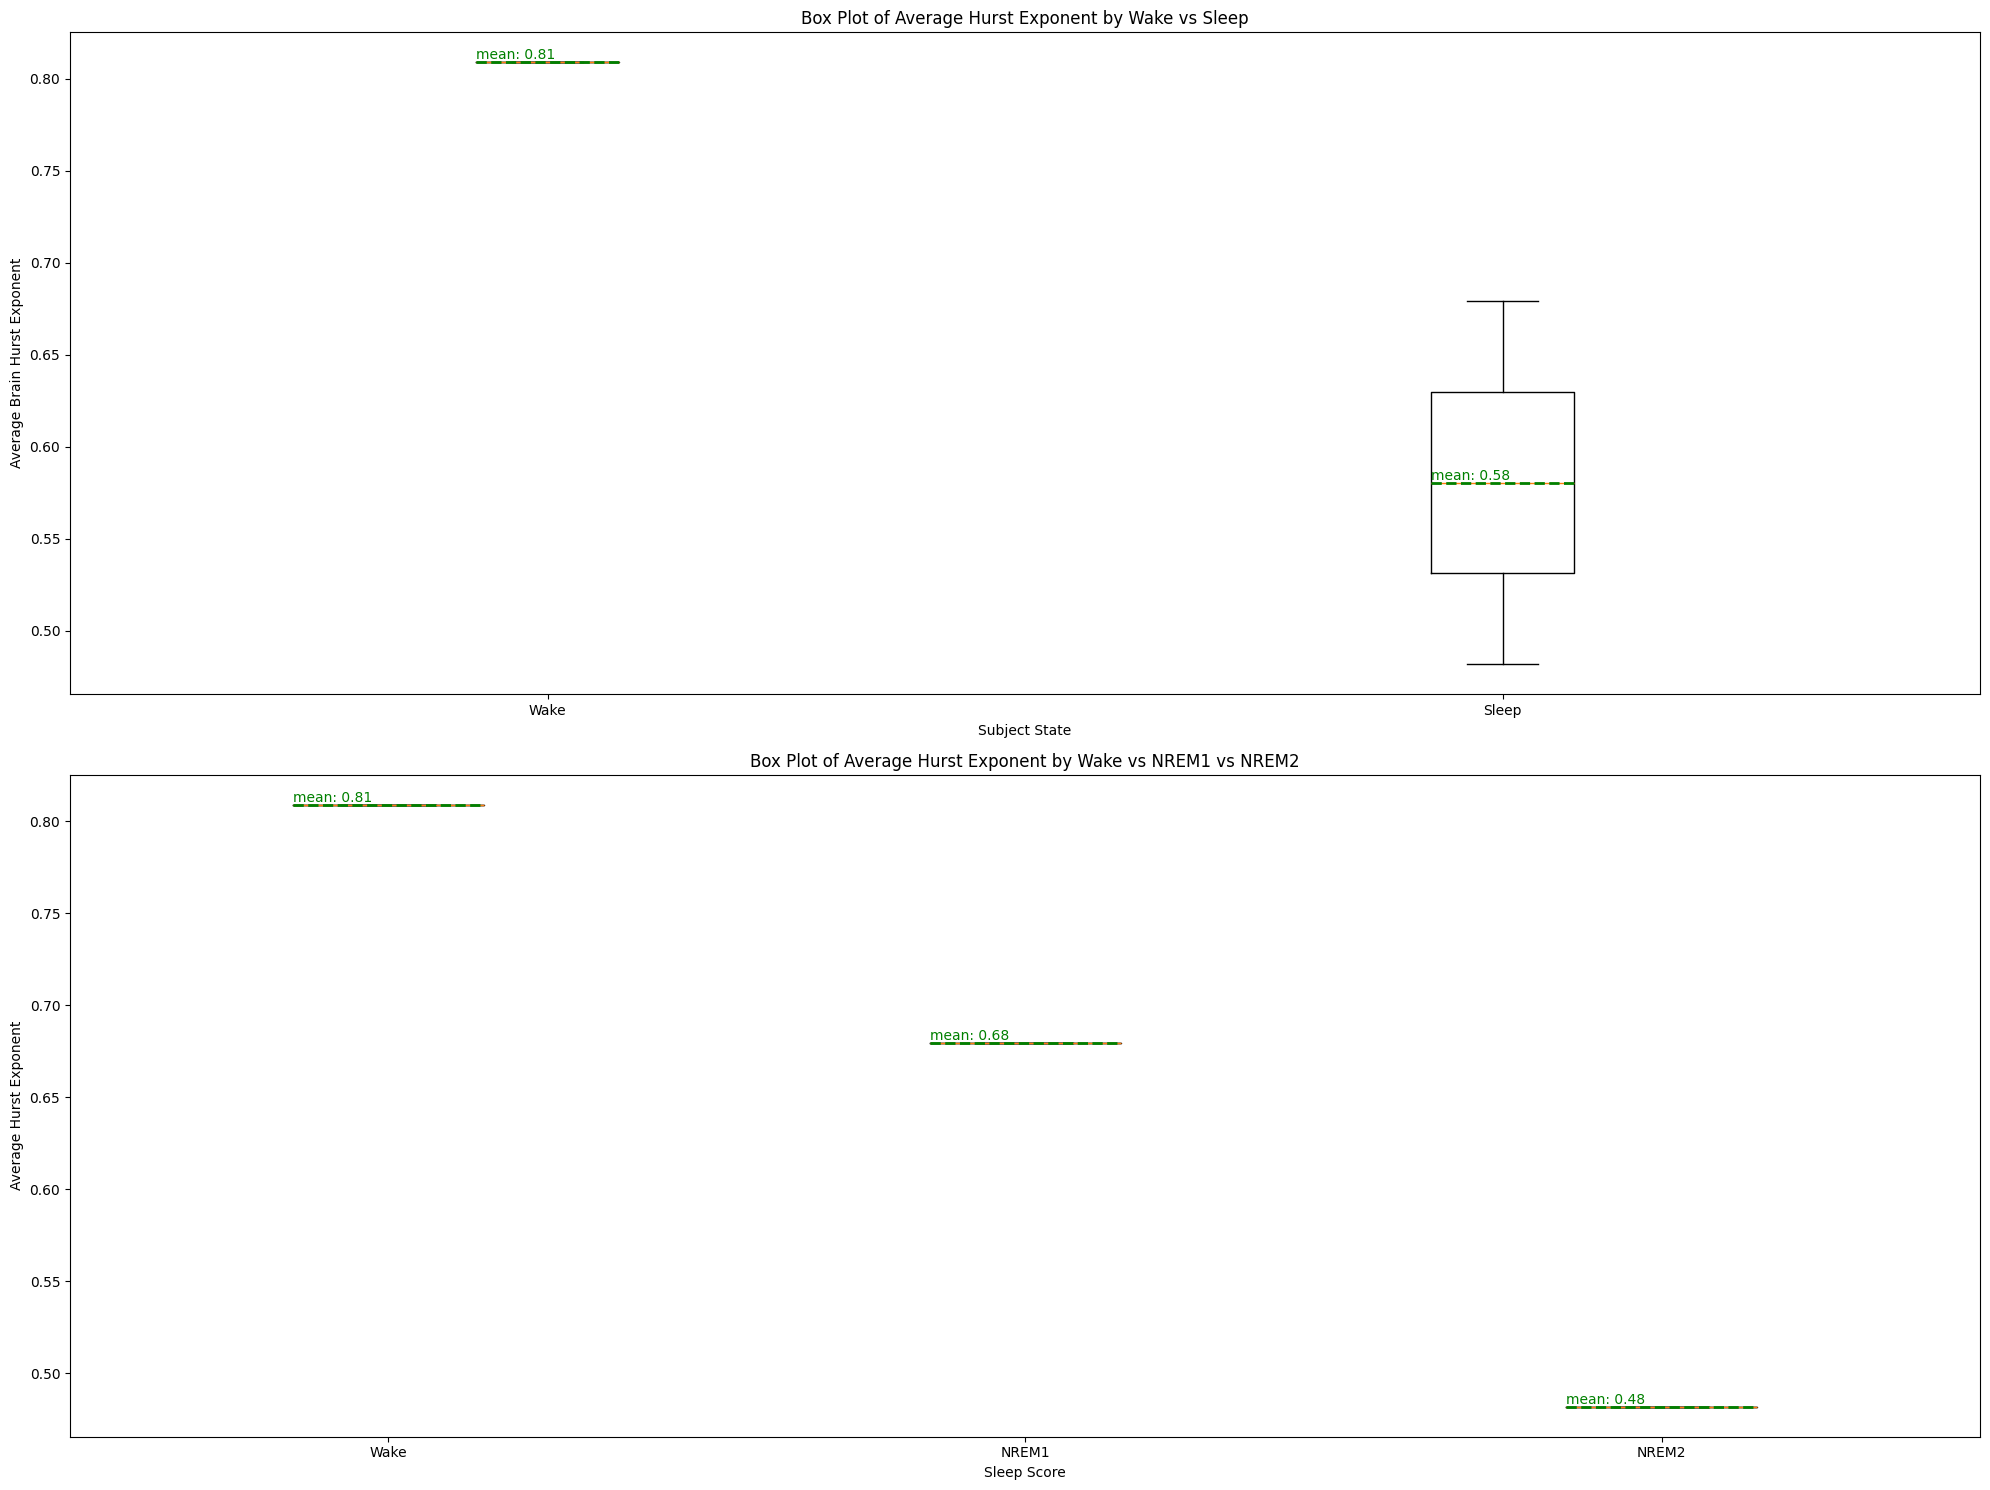

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = '../output_directory/evaluation_dataset/spectral_evaluation/spectral_dataset_roi.csv'
df = pd.read_csv(file_path)

# Extract data based on sleep stage
W_data = df[(df['sleep_stage'] == 'W') & (df['Total datapoints'] == 26) ]['Thalamus'].tolist()
_1_data = df[(df['sleep_stage'] == '1') & (df['Total datapoints'] == 26) ]['Thalamus'].tolist()
_2_data = df[(df['sleep_stage'] == '2') & (df['Total datapoints'] == 26) ]['Thalamus'].tolist()

# Combine NREM1 and NREM2 data for one of the boxplots
sleep_data = _1_data + _2_data

plt.figure(figsize=(20, 15))

# Plot boxplots for Wake vs Sleep
plt.subplot(2, 1, 1)
boxplot = plt.boxplot([W_data, sleep_data], labels=['Wake', 'Sleep'], 
                      showmeans=True, showfliers=False, meanline=True, sym='.')

# Customize mean lines
for mean in boxplot['means']:
    mean.set_color('green')
    mean.set_linewidth(2)
    mean.set_linestyle('--')
    x, y = mean.get_xdata(), mean.get_ydata()
    mean_value = y[0]
    plt.text(x[0], mean_value, f'mean: {mean_value:.2f}', 
             va='bottom', ha='left', color='green')  # Annotate mean value

plt.xlabel('Subject State')
plt.ylabel('Average Brain Hurst Exponent')
plt.title('Box Plot of Average Hurst Exponent by Wake vs Sleep')

# Plot boxplots for Wake vs NREM1 vs NREM2
plt.subplot(2, 1, 2)
boxplot = plt.boxplot([W_data, _1_data, _2_data], labels=['Wake', 'NREM1', 'NREM2'], 
                      showmeans=True, showfliers=False, meanline=True, sym='.')

# Customize mean lines
for mean in boxplot['means']:
    mean.set_color('green')
    mean.set_linewidth(2)
    mean.set_linestyle('--')
    x, y = mean.get_xdata(), mean.get_ydata()
    mean_value = y[0]
    plt.text(x[0], mean_value, f'mean: {mean_value:.2f}', 
             va='bottom', ha='left', color='green')  # Annotate mean value

plt.xlabel('Sleep Score')
plt.ylabel('Average Hurst Exponent')
plt.title('Box Plot of Average Hurst Exponent by Wake vs NREM1 vs NREM2')

plt.tight_layout()
plt.show()


t-testing script for states:

[0.32483799013671133, 0.5542369564461627, 0.18362977214554213, 0.5579131666257705, 0.4131579467431865, 0.47408213275877387, 0.9852729744921203, 0.6881280626591337, 0.011286376236280727, 0.061131781230847095, 0.5108404077378139, 0.3769404208975312, 0.882702746163684, 0.6431568712875881, 0.9371024591062189, 0.38335496895912147, 0.38706389406828867, 0.3613209392250871, 0.935940569265579, 0.8785911732399105, 0.71635669577618, 0.8578059921886061, 0.7333756154216151, 0.6116881168788395, 0.30666138671375776, 0.09299945005054376, 0.013811256059924261, 0.19861562348176828, 0.7965348439219382, 0.03233652065826914, 0.11532425876978586, 0.27589709352483716, 0.27282833173163523, 0.7879009289538781, 0.7834062503704866, 0.04068127500496175, 0.6101910674004674, 0.04306136034632105, 0.16804674776337905, 0.3018195614173634, 0.06723513222912988, 0.257395961326436, 0.4086602734878465, 0.10463285949190526, 0.29145738048153375, 0.7071563632704057, 0.5995033938016716, 0.6681101032460881, 0.26238228895133736,

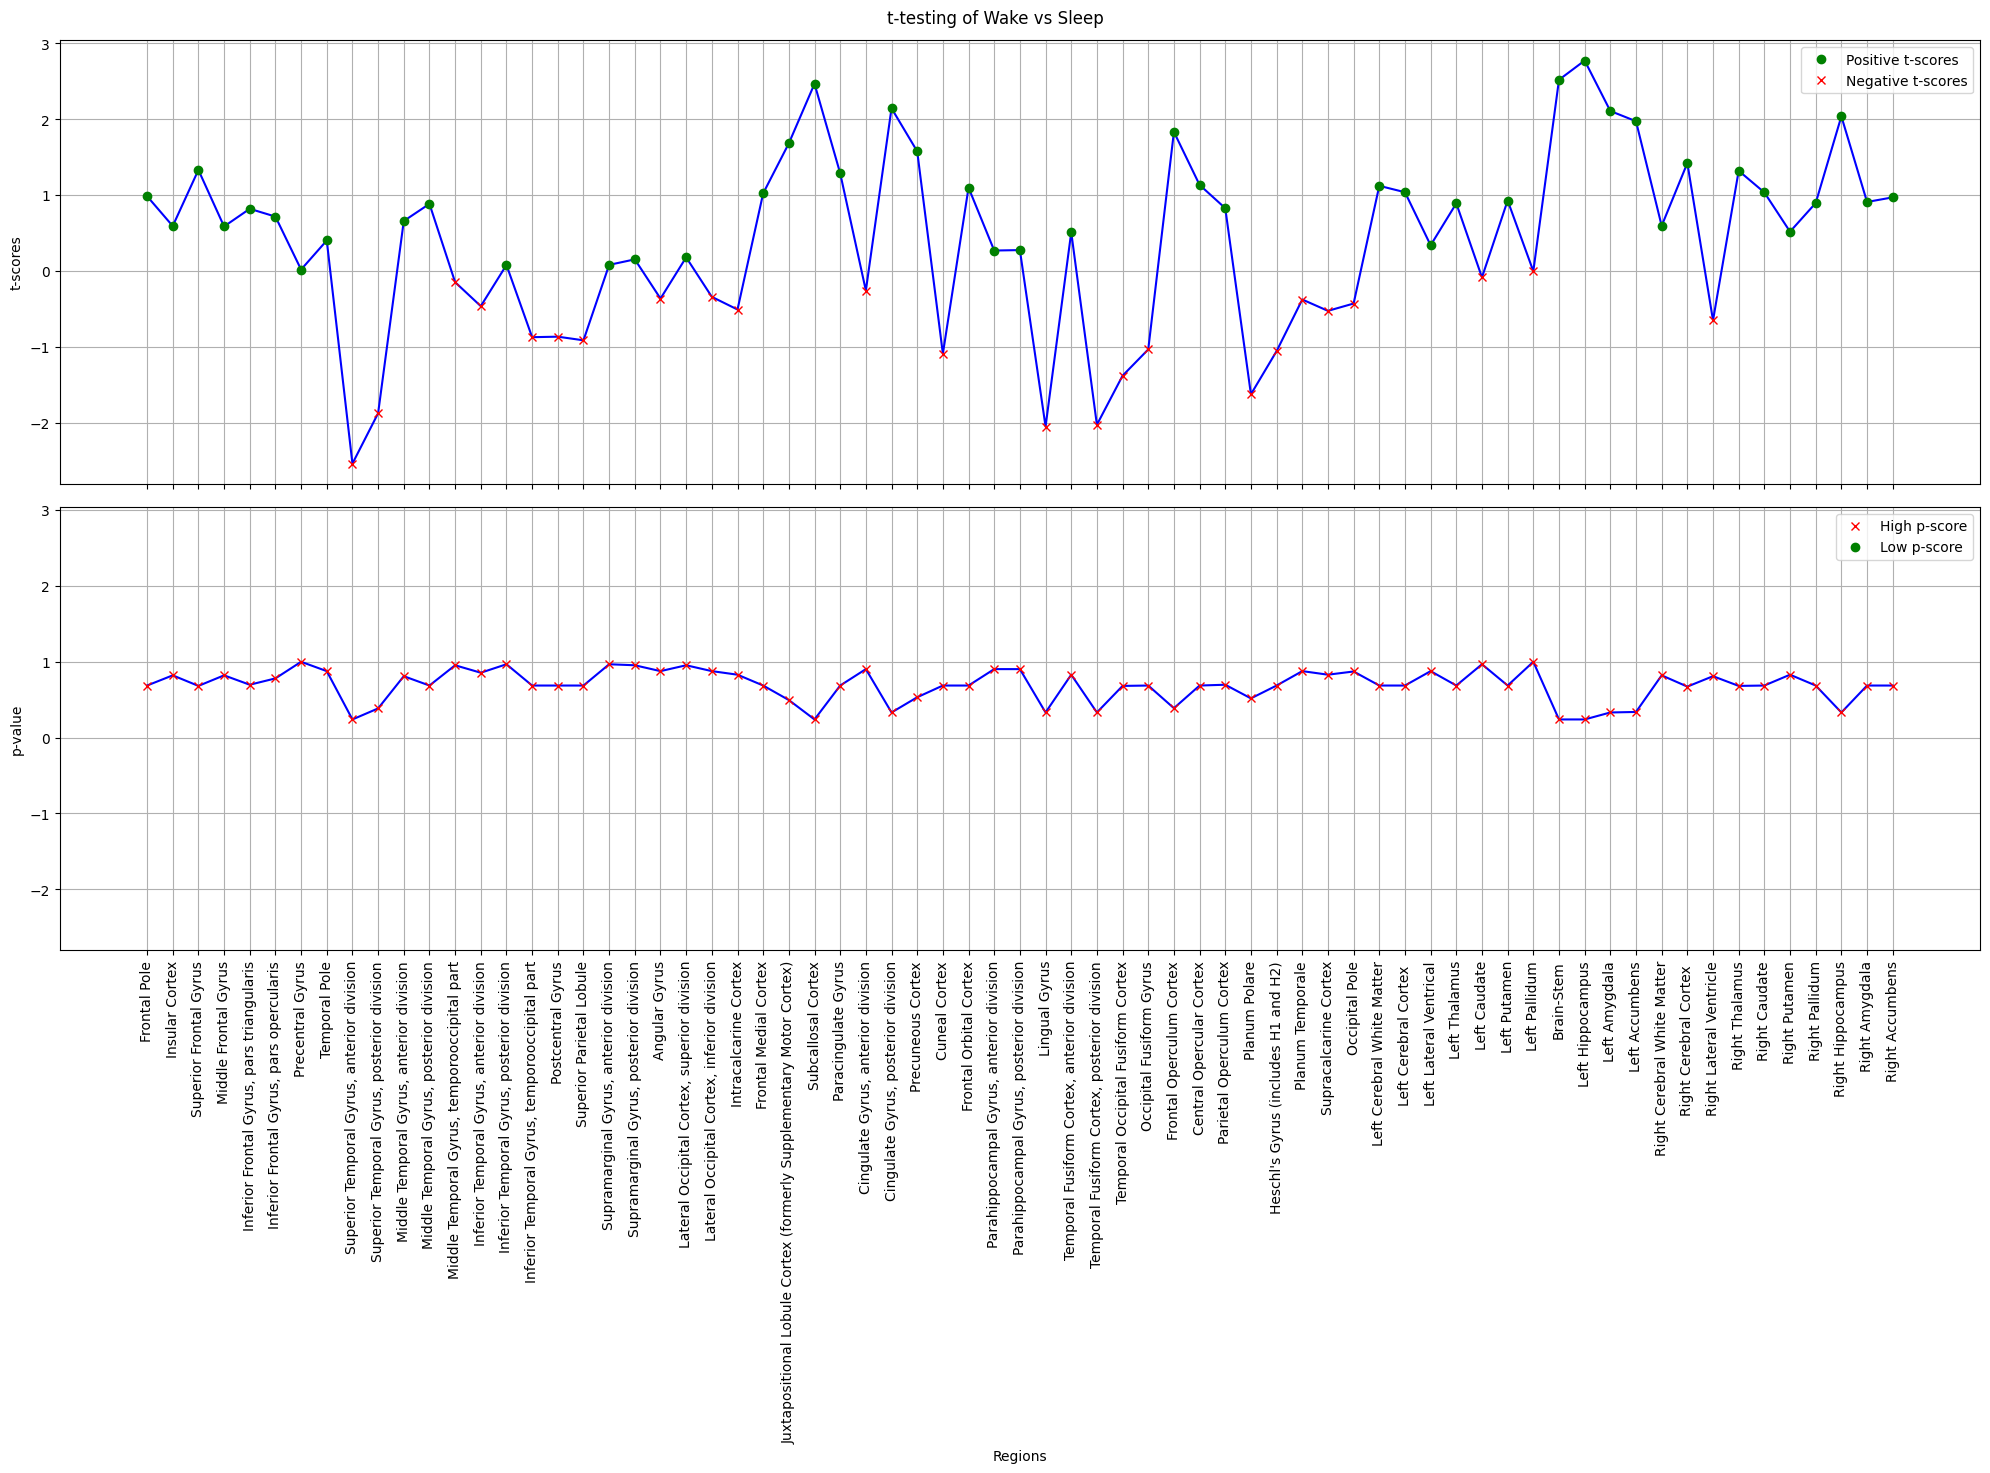

In [ ]:
from t_test import evaluate_t_test

evaluate_t_test('../output_directory/evaluation_dataset/spectral_evaluation/spectral_dataset_ho.csv', fdr_corrected = True, save_results = False)

Test Script

In [ ]:
def plot_psd(frequencies, psd,peak_freq,peak_power,spectral_entropy):
    # Plot the Power Spectral Density

    psd_normalized = psd / np.sum(psd)  # Normalize the PSD

    peak_ratio_low =-np.sum(psd_normalized[0:10] * np.log2(psd_normalized[0:10]))
    # peak_ratio_med =-np.sum(psd_normalized[11:20] * np.log2(psd_normalized[11:20]))
    peak_ratio_high =-np.sum(psd_normalized[11:24] * np.log2(psd_normalized[11:24]))

    # plt.figure(figsize=(10, 5))
    # plt.semilogy(frequencies, psd)
    # plt.title('Power Spectral Density')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Power/Frequency (dB/Hz)')
    # plt.show()

    # Print calculated features
    # print(f"Frequencies: {frequencies} Hz")
    # print(f"PSD: {psd}")
    print(f"Function Low: {(spectral_entropy)} ")
    # print(f"Function High: {spectral_entropy} \n")
    # print(f"Low Frequency: {(peak_ratio_low-peak_ratio_high)}")
    # print(f"High Frequency: {peak_ratio_high} \n")

time_series_W = [-0.6436901314198897, 1.06216207716049, 1.3592595181445914, 2.570675753777558, -0.7840740950079897, 1.5483123387935886, 1.5030688742148985, 0.721934147821553, -0.4721930935279792, 1.9476283813897803, -0.06302667495156467, 0.6256328495874249, 0.2971801934916477, 1.3534659134490419, 0.6847838491346012, -0.021246811244844344, -0.48951362517523817, -1.6575811892609513, -1.1684459249305605, -0.47857571727099246, 0.22178469090663236, -0.7211598649639362, 0.46039953940437933, 0.5842106423694656, -0.37727467976263346, -1.133222571331938, 0.3257795772581489, -0.9091390257009875, 0.61507788509018, -0.22181921682310118, -0.8678023505639287, -0.6587866726932518, -0.36599639946541174, -0.33421373659241604, -0.7445671339617109, -0.9425879450953295, 0.4238262708418927, -0.7303469195310244, -0.37541850599092846, -0.9651165155459168, -0.688233192514613, -1.4160108172302066, -0.8189240599404435, -0.34740511567265586, -2.2792060640190916, -0.35370675090756276, -0.08772037931708564, -0.2064002566237472, 1.0069207307355712, 0.25627968671241097, -0.2490714272567804, 0.06441866753942194, -0.2360331444788462, 0.013809903257917073, 0.3976042866409398, -0.6378678696962381, -1.548848516270841, -0.32232382090816303, 0.7878165491347926, -1.6007921218870302, -0.13388403731646492, -0.5615770931140726, -0.30375792109782734, 1.7503953426903134, -0.12810680084314982, 0.6913993830166785, -0.799340632348516, -0.7449655868199885, -0.3519130717404586, -0.6639029543259025, -0.3173707819296041, -1.2131339647057016, -0.21140010900356343, -0.4207824589373106, -0.23993114428854717, -0.08881133143658891, 0.03267744539783124, -0.41804641239365214, 0.2069253898421961, -1.1836105113680293, -0.11874242208741725, 0.3846370002935969, 1.0528486957730803, 1.28165801263341, 0.5051600315513423, 2.002408674738257, 2.208470589413078, 1.1180017511235367, 2.394092436896611, 1.5330501018423475, -0.7148090841874482, 1.3521225732040887, 2.301417604976624, 0.15415541953026904, 1.7337126674976344, -0.32171787573404076, -0.2923714994914598, 0.918700216661427, 1.926237001942193, 2.0574273905250955, 1.0129626011176707, 0.8277920269444311, 0.4510205384013118, 1.2776433691096447, 0.6404997944453195, 0.32548581141703403, 0.06342742156893554, 0.27211283331209996, 0.7720594175439331, 0.6749710734665421, 0.14069791399456252, -1.035317670581746, -1.707155631566988, -0.9163664720152136, 0.6950482882242198, 0.2698307694573275, 0.3212750775927151, -0.5824973608023787, 1.6252968748480754, -0.9187147344143216, -0.26624093844392743, 0.435203656568417, -0.33168630952791095, 0.5649883712174271, 0.975301509605031, -0.2068423248754706, 0.14220964742447803, -0.17094296536627088, -0.07976881678824614, 0.46078684582711604, -1.0023691682049085, -0.7243545512471561, -1.2841208043563255, -0.3363551449856894, -0.7746794623527471, 0.27242080884746844, -0.4901689219538909, 0.8020518882015548, -0.6185104696622821, -1.3804554011618424, -0.45958860784852046, -0.31802738527420144, -0.9354292081020781, 0.4135585068764095, -0.41711929443927853, -1.9388498583646752, -0.4231577257712706, -0.0170485416990774, 0.49650544578436223, -0.37544206814750036, -0.9677886026745136, -1.7582693868506005, 1.314782629342266, -0.3455901192454241, -0.10057002479836398, -0.3680638300562003, -0.4420741227677817, -0.47055439052950015, 0.43404878347313547, 0.6685602041572165, -0.9374687236361908, -1.0187019696221158, 0.1696017085921013, 0.9543132054223308, 0.14496475202590292, -0.6540188331058284, -1.3166620313691968, -0.0419310011173462, 0.5651941570853982, 0.2938014748445791, 0.17909251627151057, 0.8876988432747807, 0.9481503808680459, 0.6304277593393434, -0.5870933360350581, -0.14142044453874184, 1.103496179327045, 0.8105443799399386, -0.31126303588852694, 1.3760068446727605, 1.6261251217657238, 0.3347405807101297, -0.030316267223590005, 0.8132743751435545, 0.7483403244097198, -0.13444935930834317, 0.670476866716073, 2.162891985236163, 0.47194885756273264, -0.7628083523405216, -0.24531730019049588, -0.06782093004541777, 0.25440576396587344, -0.07276153546424981, 2.081609182043349, 0.28101356459789306, -0.5883826914555187, -0.5194955797736619, -1.2334132071707313, -0.46331983048106795, 0.21961576881981493, 0.367618074489257, -0.8938010673497842, -1.0335812183327169, -0.0704822469814697, 1.3722154271826328, -0.03477661304472567, 0.3611216537932568, 0.36040621293701813, -0.35138570945352177, 0.45581098890206334, 0.07160088256425794, 0.4325117059137833, -0.3547168540079293, -1.3152758079461362, -1.3957473343314692, -1.5008314072794586, -1.8663547500608104, -1.0074733379072773, -0.6688851936918314, -0.16313844517807813, -0.8422128346982205, -2.1272708577123733, 3.142696981316496, -0.8121011178110085, -1.2601804309749924, -0.3337872612633581, -0.8756640566256663, -0.0721626045920859, -0.34059138252143073, -0.46678111199221767, -1.1511535910415494, -0.507628367169016, -0.8539316779038162, 0.18218377795401094, -0.3563199035580562, -1.8598391834636931, 1.3182121872925932, 1.3412757576416003, 1.811874961347492, 0.8176987280512391, 0.9444480292259818, -0.12741945980278585, -1.3072204708516053, 0.04555812361452118, 1.9082951446672343, 0.41264667775707997, 0.24172308462305134, 1.098216574982763, 0.7149075046834742, -0.24044768038204328, 1.253240773781581, -0.8477116162868519, 0.05635782229776373, 0.3971474880110392, -0.6639082872921981, -0.9556009371704696, -1.256747231838679, 0.20666750758045904, -0.559558719472131, -1.256847137643267, -0.024711098510205802, -0.7758520103039847, 0.1534311502449565, -0.4373008546407134, 0.8317829933805456, -0.8981448606810903, 0.30707888498791824, 1.0635166313171454, 0.34928894734349764, 0.8709794230012707, 0.28112152913783583, -0.4872901070585281, 1.9463553011341492, 0.23237516626217614, 0.21846671626461145, 0.10255513511370153, -0.24551055837511107, 0.164034264027531, 0.030308062728838434, 0.00580925672562331, -0.6841749851186746, -1.4571410851817792, -2.107840312104365, -1.5672522520338374, -0.7183268310125545, -0.6069747686843853, -2.7940962111060323, -0.2649902549919385, -0.023748538136973283, 0.0804053114313819, 0.07259884644304532, 1.783131685858889, 0.3796596050580061, -0.2187483253980725, -0.5144968721065237, -1.5866241751284582, -0.9252670610059999, -2.6947317810827647, -0.894032170700288, -0.3072875848758244, -0.7442463509579641, -1.1434612347522066, -0.4709471449552491, -1.01630044747024, -0.20704426543212212, -0.2810479851738386, -0.6262723576980497, -0.44914381934981684, -1.8980826673457383, -1.4499517687247538, -0.4581295825718931, 0.48865757533940707, -0.3636001540804282, -0.45114341652156326, -1.2823410471538566, -1.2348119727333067, -0.2346953936775649, 0.0024159885554294507, -0.6734179611754, 1.513975446696771, 1.94138113440191, 1.3588293957891515, 0.09194679170152201, 0.30350123809866825, 2.72343623919885, 2.9821096846894424, 1.2675036358652358, 1.7662067985056056, 1.6008153821494284, 0.9380214270226854, 0.5706790267991658, -0.13633501391330055, 0.9390848429162785, -0.09194342062066999, -0.40651668255403695, -0.6469051079991398, 0.39546084493209777, -1.1135198534188293, -1.1275041096864538, -0.7817148085108361, 0.4987552281752479, 0.5208337670088933, 0.8934683899909694, -0.5714016864413011, -1.0965893291835074, 0.5094107206966941, 1.3056193469610486, -0.007076412709354603, 0.9349744495795697, 2.0942597321551957, 2.680321282183922, 1.318011859001631, 0.26032532432085437, 0.16672161700916466, 0.24218966739438025, -0.29998892944023614, -0.7602853548666252, 0.5236014240094641]
time_series_1 = [0.35148797693584255, 0.6458673877605142, 1.0660490201374524, 1.3545738474493794, 0.8807328626364995, 1.2437847354731004, 1.8203386893138127, 1.1309464577964252, 1.1789462610291963, 1.113316337253343, 0.584726642624771, 0.04599327225417759, 0.33224721295350956, 0.33582956417811244, 0.8003637089035193, 0.2976923159499137, 0.39502022628717265, 0.8280984750857796, -0.4335848668178394, 0.1589080352036422, 0.9831980410635529, 0.5705270945679154, 0.8294715754485323, 0.4610390002486637, -0.29184132284818, 0.39166258274659216, -0.05046259978827113, 0.7711982281364373, -0.07190713124170947, 0.5347611560913736, -0.2915252919670615, 0.6328358907104632, -0.5896764753687134, 0.13317733772684473, -0.1574297690484467, 0.24447863406166254, 0.33207189568924667, 0.49700638388691665, 0.0025088834340842884, 0.6604754452159526, 0.6380415500562897, -0.016724493749308948, 0.6664272372604692, 0.5387081489833864, -0.07781778700522644, 0.6291995306002066, 1.1227533316288105, 0.0711290918603971, -0.24328350923412342, 0.5639438106605995, -0.008138127513312714, 0.036733904589521756, 0.7871626422119756, 0.8531204597549981, 1.0274930182251443, 0.2389674542790487, -0.4003360052413632, -0.05262545917223268, -0.47451728389498243, -0.27179657041372485, -0.01149175974972927, -0.06104579689103403, -0.2788669923175552, -0.07816269226010746, 0.007872266132029225, 0.02585932201813202, -0.8665250447373595, 0.18487588956463755, -0.3582960485412638, 0.6553195771465933, -0.08407476409357797, -0.5919587503831799, -0.8508680933626342, -0.3659838974675628, 0.6249940377400062, -0.15033145703634082, -0.20170302496419784, -0.7330011874520321, 0.27722204916437376, -0.41102528931688886, 0.10145765886955431, -0.4137902734187665, -0.8096050202710294, -1.1715828645717485, -1.2561212499275294, -0.7806121920590046, -1.6234662807816926, 0.3808962817046354, -0.49441738186842094, -1.6662935984321667, -1.2721619326313318, -0.6579840953373132, -1.9704641919921295, -0.9245781030461611, -1.0319237556107559, -1.0362001207780571, -0.9916176773848411, -0.5146213664989314, -0.8219418493783746, -0.3857271551386661, -0.07614810961265334, -0.6517825102987193, -0.5926375220365522, -0.6921385122121027, -0.14261290383567604, -1.0474675177000916, -0.8557393636438032, -0.4599069443444465, -0.46866654869853536, -1.3531124161734809, -0.6243775443627825, -0.5022784183467514, -0.7897191434493263, -0.2333536856593221, -1.1169714660500907, -1.4700405863005537, 0.9521548158567623, -0.5120627246677674, -1.3895072535608373, -1.024987072846626, -1.848163248061566, -1.5015855311043609, -1.8081956548659668, -1.9377722569935605, -2.7604822697319764, -1.6403816220682084, -2.037278013530787, -1.9924133335115948, -1.731261152886156, -2.1904669031330575, -2.7421636570940797, -2.3774943876182215, -2.5928503241793384, -1.089206835823603, -3.2648138340483253, -2.28732451530539, -1.4356386528182952, -2.540706090843485, -2.100405284092437, -2.125921065522589, -2.0457982145702927, -1.5743158508827058, -1.8472891990054656, -1.5811869000274468, -1.231662650272272, -1.3819817110289196, -1.5576220156565523, -1.4593759159854678, -0.780342361417403, -2.265236195552626, -1.5523635706064836, -1.7640124637646453, -1.2139814217224787, -0.46481428396304453, 1.2312078326527343, -0.2520593384541791, -0.5375933976996168, -0.22643501947250025, 0.7395619819732251, 0.3636084325119371, 0.05892069814314852, 0.8991507366859627, 0.8342394611336461, -0.23014487453898125, 0.40550577820936196, 0.6531492393328134, 0.9175317140461853, 0.6744944787396301, 0.23440775333662905, 0.5367768528059808, 2.8307633059149877, 1.0284866146600073, 0.41718892933092677, 0.2868812205411518, 0.3243410894910089, 0.8741018650662276, -0.07870673027619716, -0.48060444455164614, -0.9664537479437265, -1.1661657368065836, -0.06756371769048895, -1.0031487847432983, -0.7207564774810503, 0.4426263502305588, 0.026229808910023973, 0.11664845861985058, 0.7797918083793559, 1.1002195387551845, 1.8235180195283323, 1.1149633527631084, 0.4888424090202493, 1.1249382490922817, 0.5615997650437334, 2.1691679607130365, 1.9940203432162846, 2.997016267331247, 1.1398741703866722, 1.2990321609957025, 1.788485852733895, 2.3916386035387838, 2.630672395449566, 1.1539672654258384, 0.8634809535927067, 0.7124414603984482, 0.5775557831403182, 0.9462680687144589, 1.2340864831140086, 1.5014622142315257, 1.0162522576557056, 1.1945469245901486, 0.40310476788552774, 1.653175348331999, 2.1032852296013473, 0.7606537282030431, 2.015691291896992, 1.1830145383958401, 1.5357477728646454, 1.695359620946122, 1.8608040554346048, 1.3637383523723823, 2.6857849256061557, 1.380062826560123, 2.1552188682012945, 2.5658921726833506, 1.22950714550638, 2.085145428625735, 1.5983176375058312, 1.5324798333322756, 1.9600128786822901, 0.5119788490659154, 0.5539949026973406, 0.062281089591402036, 1.091190396499227, 0.3275281005980757, 0.9004926634748759, 0.6835319673608775, 0.49553859906255027, 0.8819633683181336, 1.0194639893645288, 1.3085250378601914, -0.18676172884154424, 0.5871140834806515, 0.7685512190182103, -0.07386036724346788, 1.5110881783274486, 0.9852244269711116, 1.1622033162291465, 0.5010113772733584, 0.6372545489309062, 0.09967750767418238, 0.35699626537943413, 0.491340247654202, 0.6183862468331244, 0.22126841965562274, 0.03800265003646833, 0.5856695669330185, 0.21828591778547407, -0.3333320754584008, -0.4236670559783272, 0.6347936717420246, 0.5654144196643229, 0.7566120843023291, 0.39306965802543126, 0.2532670950151023, 2.4404007747947354, 0.9373631820593997, 0.7178654042424598, 0.6417215569600453, -0.5518506779765662, 0.10298084915075488, -0.4587683225656103, -0.5391338607869786, 0.7008050585265958, -0.22995429979927243, 0.3244493682355321, 0.51909555446276, -0.3853443446321168, -0.08916534706374737, 0.2611622720251351, -0.629850252513351, -0.3186648645541535, -0.5066736932787405, -0.6647752719331805, 0.6589132528272817, -0.3452852328162784, -1.4736897260445514, -0.3526284446974902, 0.528134253235923, 0.19553516016241035, 0.22513199733262576, 0.0560079716056625, -0.20042043457300104, 0.8867676329268672, -0.6319433234025564, -0.05169388528452885, -1.134569486022624, -0.37303370697844185, 0.389982685298019, 0.11247451565603121, 0.22115784421291318, -0.2516921503389594, -0.4767268351540844, 0.29881769053558194, 0.7467849478924844, -0.03647854613485109, 0.6543549781525165, -0.002660626271934588, 1.0149140590262429, 0.46273888250935313, 0.7186597867136347, 0.7502375440060474, 0.41900783977036477, 0.13536176586424523, 0.943137187308987, 0.40447112579432626, 0.9627898090152057, 0.2716754113211498, -0.9835450138801912, 0.3342611617691663, -0.9812924217337491, -0.2953367657935909, 0.4681143072286359, -0.8150637657132317, -0.47766638832225977, -0.5579398146773258, -0.8851220154482352, -0.6838948625091966, -1.395369751407383, -1.3926083094571813, -0.42350177332629474, -0.24528720398459414, 0.5168970604919214, 0.8075431725635248, -0.322643632757095, 0.6710443993066048, -0.91191776264736, -0.387777797464217, -0.655283278120999, 0.8772158434210964, 0.4544203429132411, 0.06971451405647223, -0.7003550321529385, 1.37739793493122, 0.49954421825858536, 0.5555802176334056, -0.31442467211232267, -0.7018022349784007, -0.8272513362961886, -0.5437462895482377, -0.3742831191097674, -0.48766417406917795, 0.19390359206894872, -0.37407332809150895, -0.33474785332032514, -1.498037616032358, 0.4855305404469766, 0.01431214059379147, -0.7491106070255762, 0.6571063366123012]
time_series_2 = [1.1965035755194338, -0.041321947833170315, 0.38375249934746347, 0.14129123600782517, -0.017023497555005398, -0.38700943306164226, -0.15612635320748647, 0.22940624764565182, 0.4369546323343986, -0.1841625621328475, -0.3824871216552158, -1.0918599618003193, -1.523951810057141, -1.1739831591759293, -0.824903254479479, -0.8882258967274762, -1.3935429586799573, -0.2376573830205879, -2.0676255372607484, 0.0643328380551793, -2.1542217126039653, -0.7617761651001722, -1.7880062288130525, -0.8234996686182737, 0.6726396715426686, 0.10509251540535808, 0.25692258700910103, 0.7508875802196335, 0.646547937315279, -0.6348272036409349, 0.7222343762850121, -0.9181735685820553, -1.3986113026993396, -2.295360461644485, -0.1457486481306318, -1.770321218645579, -0.2708249415128666, 0.38200000368158976, -0.1060644058009295, 0.3995071598553332, -0.8137784792230187, -1.0986743004874608, -0.2637472215484287, 0.20444009190507112, -0.45203352275071323, -0.3599403455248481, -2.451088786477949, -1.286223997531895, 1.3620813105462652, 1.4790672493101267, 1.130165244073813, -0.0038995066442509005, 0.20821996781186516, -0.21304795454171543, 0.4803097582801325, 0.26882139586905696, 0.9042150443477031, 1.3710447457477282, 0.3546780914990681, 0.6384328761054417, -0.08555178605794797, 1.13563240139108, -0.8560737442207855, -0.4698016119522073, -0.3043006311266168, 0.0022727876242515737, 0.6038521255625287, -1.5335962917171078, -0.9876079489341711, -0.46288275525058525, 0.11218290095592393, -1.8424797638083412, 0.4718090804626606, -0.6962580631971477, -1.2280281494214582, -0.1650410080644774, -0.22578153665022868, -0.8950180561748843, -0.8165926524959128, -1.0912734750352129, -1.7469412082564724, 0.07927997347517436, 0.41141799087815734, -0.20645753240671183, -0.08562886580630281, 0.6792263865479059, 1.0827208129417354, -0.1263220628326681, 1.0918426404148047, -0.018947946530309873, -1.4919936023508928, -0.8514802318099309, -0.7867653722301365, -0.30402058483545336, -1.436116130754068, 0.9718172862028323, -0.599347496978078, 0.9655893177326528, 0.4827996186671447, 1.0912684931697523, -0.20220766870198623, 0.014991487808423676, -1.4271655532584644, 0.6230009194909882, -0.48715127683106235, 0.1398903196151019, 0.7546790444183789, 0.1925232582404296, -1.0375960663024137, -1.6925541651230274, 0.5420979779673709, 0.3049285546603585, 0.06925772803614481, -0.14912925730171137, 0.7671793545629882, 1.069704850482645, 0.14614138140937655, -0.35710753656465494, 0.42348535184929775, -0.4209331970320124, -0.5048851130257326, -2.0711244189504776, -2.047092641596239, -1.7008905540050812, -0.6808650054022042, -1.220131281528289, 0.36368731609405053, -0.17187773248892996, -0.4494421318688942, 0.06283174463309289, 0.06184757694561467, -1.152337856732742, 0.7960626809953939, 0.2275433204733264, 0.5924812445067186, 0.5361659610172718, 0.09826803040340937, -0.24736882833503654, -0.8615135074157098, -0.5521940639239811, 0.11409911352332315, 0.08340581906146768, 1.2563366023085971, 0.3641321939596118, -0.02230600219466888, 0.7561356504109764, -0.10029921257561271, -1.74165425804931, -1.291840733847893, -0.6522481024281231, -0.9511828916455048, -0.8005996091839662, -0.63318007677065, -1.2458156661960176, -1.3894595500660538, -0.3732271894223234, -0.9853108146481169, -0.2198326141033626, 0.6529277114757145, 1.6754792865055712, 1.2860854754307551, 1.0141656615120886, 0.6871218284804724, 0.2147501722856166, 1.226212187416183, 1.0171050142131695, 1.052893764905167, -0.12052753317081046, 1.219833252195961, 1.2401750304845338, 1.2522464171250232, 1.8825073990589132, 0.01759937499449157, 1.0602211787421965, -0.9501366144117046, 2.8445865987139314, 2.105924147520413, 1.4046012522771112, 2.5033783892645314, 1.2933210661868264, 1.8575568348891396, 1.2092212595146863, 1.2232469703053586, 1.68823602638355, 2.461912504471451, 2.087594712258554, 2.3367449489443954, 1.6054067233030505, 0.17213397001234904, 0.2111010756535182, 0.950110302693412, 2.180071485846209, -0.7297948136301742, 0.38973102973636237, 0.5987005499418534, -1.1123547357202324, -1.8568643806458487, -0.5395230933712915, -2.3415935876685516, -0.09168140102605013, -1.393526816795582, -1.540564216581408, -0.8880203212658234, -0.2820534316770547, -1.2745339752071299, -1.1373002886113392, -1.3413351115467536, -1.174952998040493, -1.6995766220193338, -2.233332530602102, -1.8477678916820381, -2.5986548386000816, -1.3514910752041807, -1.034647547471919, -0.13734847400186076, -1.5884216565934661, -1.5620410410034073, -2.015793523761535, -1.4708505448583613, -0.03200397422887947, -0.1803254891340143, -0.06681453600813075, -0.10618598772453858, 0.28559557151357023, 0.3039244629310611, 0.3584546079922138, 0.4989663937371493, 1.0290854726416385, -1.3457926629178631, 0.9607136769838398, 1.5951930986339093, 1.2205808622031356, 1.8145594702472283, 1.2684938888494797, 2.3167834856266776, 1.3010166112364032, 1.1187801333642737, 1.2898409671398572, 1.2744113841364266, 1.156049605421256, 0.1623038870583167, -1.4058993709020084, -2.980004816459465, 0.3992202669106571, -1.1880983624505037, -1.3918689944000058, -0.004487236973245877, -0.47037068087044276, -0.5156914291608212, -0.3803248214882219, -0.9891180677879964, -0.7706400052811083, 0.7973186634101024, -0.8286921335917797, -1.0667191802470717, -0.3402478268478193, -0.5416142224415772, -0.17767534797251555, -0.26324257095095815, -0.5858506707682701, -0.3501922280920569, 0.39875041105065656, -0.08735610046498848, 1.4409636196293023, 0.7664629737665557, 1.0751364354756798, 0.3617463944956977, 0.18899846792913472, 1.6468896502444814, 0.19083023563124552, 0.9718181244586032, -0.5210112455794318, -0.7843703981809008, 0.13724483441097562, -0.6588012676705238, -0.7209250141117032, -0.17418128406113823, -1.401569247439553, -0.08107774946851877, 0.6547489472832485, -0.914539717738327, -0.06649741770516646, -0.8861669995922687, -0.20903056989603017, 0.04569295574514711, -1.1475378634787068, -0.05099140836840838, -0.35423059227189563, 0.8355402644227344, 0.5220889034816257, 1.011949453726045, 0.7613000426353538, 1.5478916115971981, 0.9334594715840298, 0.8469985265622316, 0.3746514593874161, 0.3230959289372448, 1.479919495703287, 0.11377389391336187, 1.1242171913747603, -0.0009633899488537832, -0.27432378859319917, -1.0007521526906449, -0.7921045272216837, -0.8213111235878351, -1.1107453376963814, -0.1966436667418231, 0.16247480493173247, 0.8330879254615574, -0.18799334306488788, 0.6445478387905701, -0.4090103685633292, -1.3139019318388163, -0.40998530735450867, -1.1409417487664308, -0.4652521910695142, 0.18951058914533966, 0.03056748404837342, 0.12595209753140826, -0.7930788236758701, -0.6726001253030389, 0.5789791090269955, 0.21972922392177235, -0.427004857604075, -0.5972808096522888, -1.1312481723536194, 0.17169246672313454, -0.5159610417901442, 0.39273642083107824, -0.2511584590304972, 1.2904491309486659, -1.219917730022405, 0.35400498999398794, -2.2001351467961876, 0.34264883913366895, 0.7887009177658166, 0.357811996129379, -1.0919418375538552, 0.18776008212130604, 0.20596644602078967, 0.5600775404917049, 0.34503844257032934, -0.3850508431971607, 0.2742135424526182, 0.37872197010040914, 0.923103392737922, -0.29578570779673835, -0.21001611587294078, 1.1683451713140343, 1.31662972897966, 0.9449196602575006, 0.7640269707635021, -1.5833080733166018, -0.9543471985763173, 0.02215089613931405, -0.3390255561311502, 0.8464465220038326, 1.2002297598469225, 1.2912235452353662, 0.10373946930161441, 0.8667840019182473, -0.057215923952661854, -0.9828447719264284, -0.6296666297187558]

frequencies_W, psd_W,peak_freq_W,peak_power_W,spectral_entropy_W = get_spectral_features(np.array(time_series_W),False)
frequencies_1, psd_1,peak_freq_1,peak_power_1,spectral_entropy_1 = get_spectral_features(np.array(time_series_1),False)
frequencies_2, psd_2,peak_freq_2,peak_power_2,spectral_entropy_2 = get_spectral_features(np.array(time_series_2),False)

plot_psd(frequencies_W, psd_W,peak_freq_W,peak_power_W,spectral_entropy_W)
plot_psd(frequencies_1, psd_1,peak_freq_1,peak_power_1,spectral_entropy_1)
plot_psd(frequencies_2, psd_2,peak_freq_2,peak_power_2,spectral_entropy_2)


Power spectral Density of the sleep stages.

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from nilearn import datasets, input_data
from nilearn.signal import clean
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

def get_psd_bold(fmri_filename):

    # Load the Harvard-Oxford atlas
    atlas_dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    atlas_filename = atlas_dataset.maps
    atlas_labels = atlas_dataset.labels
    masker = input_data.NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
    time_series = masker.fit_transform(fmri_filename)

    matrix_array = np.array(time_series)
    mean_array = np.mean(matrix_array, axis=1)
    
    window_length = 100  # in seconds
    window_length_volumes = int(window_length / 2.1)
    
    # Initialize variables to store spectrogram and frequency information
    avg_psd = np.zeros((window_length_volumes // 2 + 1,))
    num_regions = time_series.shape[1]

    # Compute spectrogram for each brain region and average them
    for region_index in range(num_regions):
        time_series_region = time_series[:, region_index]
        frequencies, _, psd = spectrogram(time_series_region, fs=1 / 2.1, window='hamming', nperseg=window_length_volumes)
        avg_psd += psd.mean(axis=1)

    avg_psd /= num_regions

    # frequencies, _, psd = spectrogram(time_series[:,4], fs=1 / 2.1, window='hamming', nperseg=window_length_volumes)

    #Normalzing PSD values
        
    log_psd = np.log(avg_psd)
    min_psd = np.min(log_psd)
    log_psd = log_psd + np.abs(min_psd)
    log_psd_norm = log_psd / np.max(log_psd)

    # Define a function for the 1/f trend
    def power_law(x, a, b):
        return a * x + b

    # Fit the power-law model to the data
    popt, pcov = curve_fit(power_law, frequencies, log_psd_norm)

    # f_inv = 1 / frequencies
    # max_f_inv = np.max(f_inv[np.isfinite(f_inv)])  # Find maximum finite value
    # normalized_f_inv = f_inv / max_f_inv
    # normalized_f_inv = np.append(normalized_f_inv, normalized_f_inv[-1])

    normalized_trend = power_law(frequencies, *popt)
     

    return time_series[:,4],frequencies, log_psd_norm, normalized_trend


def function_to_plot(x,y,label,xlabel,ylabel,title):
    plt.plot(x, y, label=label)
    # plt.plot(frequencies_w, normalized_freq_w, 'r--', label='1/f Trend')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

time_series_w_raw, frequencies_w_raw, log_psd_w_raw, normalized_freq_w_raw = get_psd_bold("../output_directory/sub-08/func/sub-08_task-rest_run-2_bold.nii.gz")
time_series_1_raw, frequencies_1_raw, log_psd_1_raw, normalized_freq_1_raw = get_psd_bold("../output_directory/sub-16/func/sub-16_task-rest_run-2_bold.nii.gz")
time_series_2_raw, frequencies_2_raw, log_psd_2_raw, normalized_freq_2_raw = get_psd_bold("../output_directory/sub-03/func/sub-03_task-rest_run-1_bold.nii.gz")

time_points = np.arange(len(time_series_w_raw)) * 2.1

plt.figure(figsize=(25, 10))

plt.subplot(2, 3, 1)
function_to_plot(time_points,time_series_w_raw,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of W')

plt.subplot(2, 3, 2)
function_to_plot(time_points,time_series_1_raw,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N1')

plt.subplot(2, 3, 3)
function_to_plot(time_points,time_series_2_raw,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N2')

plt.subplot(2, 3, 4)
function_to_plot(frequencies_w_raw,log_psd_w_raw,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score W')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.subplot(2, 3, 5)
function_to_plot(frequencies_1_raw,log_psd_1_raw,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N1')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.subplot(2, 3, 6)
function_to_plot(frequencies_2_raw,log_psd_2_raw,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N2')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.suptitle('Comparison of PSD and 1/f Trend for Different Sleep Scores (Raw)')

plt.show()


time_series_w_preproc, frequencies_w_preproc, log_psd_w_preproc, normalized_freq_w_preproc = get_psd_bold("../output_directory/sub-08/func/sub-08_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
time_series_1_preproc, frequencies_1_preproc, log_psd_1_preproc, normalized_freq_1_preproc = get_psd_bold("../output_directory/sub-16/func/sub-16_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
time_series_2_preproc, frequencies_2_preproc, log_psd_2_preproc, normalized_freq_2_preproc = get_psd_bold("../output_directory/sub-03/func/sub-03_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")

time_points = np.arange(len(time_series_w_preproc)) * 2.1

plt.figure(figsize=(25, 10))

plt.subplot(2, 3, 1)
function_to_plot(time_points,time_series_w_preproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of W')

plt.subplot(2, 3, 2)
function_to_plot(time_points,time_series_1_preproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N1')

plt.subplot(2, 3, 3)
function_to_plot(time_points,time_series_2_preproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N2')

plt.subplot(2, 3, 4)
function_to_plot(frequencies_w_preproc,log_psd_w_preproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score W')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.subplot(2, 3, 5)
function_to_plot(frequencies_1_preproc,log_psd_1_preproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N1')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.subplot(2, 3, 6)
function_to_plot(frequencies_2_preproc,log_psd_2_preproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N2')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.suptitle('Comparison of PSD and 1/f Trend for Different Sleep Scores (Preprocessed)')

plt.show()

time_series_w_postproc, frequencies_w_postproc, log_psd_w_postproc, normalized_freq_w_postproc = get_psd_bold("../output_directory/sub-08/func/sub-08_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz")
time_series_1_postproc, frequencies_1_postproc, log_psd_1_postproc, normalized_freq_1_postproc = get_psd_bold("../output_directory/sub-16/func/sub-16_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz")
time_series_2_postproc, frequencies_2_postproc, log_psd_2_postproc, normalized_freq_2_postproc = get_psd_bold("../output_directory/sub-03/func/sub-03_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz")

time_points = np.arange(len(time_series_w_postproc)) * 2.1

plt.figure(figsize=(25, 10))

plt.subplot(2, 3, 1)
function_to_plot(time_points,time_series_w_postproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of W')

plt.subplot(2, 3, 2)
function_to_plot(time_points,time_series_1_postproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N1')

plt.subplot(2, 3, 3)
function_to_plot(time_points,time_series_2_postproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N2')

plt.subplot(2, 3, 4)
function_to_plot(frequencies_w_postproc,log_psd_w_postproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score W')

plt.subplot(2, 3, 5)
function_to_plot(frequencies_1_postproc,log_psd_1_postproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N1')

plt.subplot(2, 3, 6)
function_to_plot(frequencies_2_postproc,log_psd_2_postproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N2')

plt.suptitle('Comparison of PSD and 1/f Trend for Different Sleep Scores (No Filtering, only Smoothing)')

plt.show()



Multiple subjects with W'S

In [ ]:
fmri_subjects_1_postproc = [
    "../output_directory/sub-16/func/sub-16_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-18/func/sub-18_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-25/func/sub-25_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-11/func/sub-11_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-14/func/sub-14_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
]

fmri_subjects_2_postproc = [
    "../output_directory/sub-03/func/sub-03_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-31/func/sub-31_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-25/func/sub-25_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-03/func/sub-03_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-01/func/sub-01_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-16/func/sub-16_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-24/func/sub-24_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
]
fmri_subjects_w_postproc = [
      "../output_directory/sub-02/func/sub-02_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-05/func/sub-05_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-06/func/sub-06_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-08/func/sub-08_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-10/func/sub-10_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-10/func/sub-10_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-12/func/sub-12_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-17/func/sub-17_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-19/func/sub-19_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-20/func/sub-20_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz"
]


log_psd_1_postproc_avg = np.zeros((24,))
for filename in fmri_subjects_1_postproc:
    time_series_w_1_postproc, frequencies_w_1_postproc, log_psd_w_1_postproc, normalized_freq_w_1_postproc = get_psd_bold(filename)
    log_psd_1_postproc_avg += log_psd_w_1_postproc

log_psd_1_postproc_avg = log_psd_1_postproc_avg/len(fmri_subjects_1_postproc)

log_psd_2_postproc_avg = np.zeros((24,))
for filename in fmri_subjects_2_postproc:
    time_series_w_2_postproc, frequencies_w_2_postproc, log_psd_w_2_postproc, normalized_freq_w_2_postproc = get_psd_bold(filename)
    log_psd_2_postproc_avg += log_psd_w_2_postproc

log_psd_2_postproc_avg = log_psd_2_postproc_avg/len(fmri_subjects_2_postproc)

log_psd_w_postproc_avg = np.zeros((24,))
for filename in fmri_subjects_w_postproc:
    time_series_w_w_postproc, frequencies_w_w_postproc, log_psd_w_w_postproc, normalized_freq_w_w_postproc = get_psd_bold(filename)
    log_psd_w_postproc_avg += log_psd_w_w_postproc

log_psd_w_postproc_avg = log_psd_w_postproc_avg/len(fmri_subjects_w_postproc)



In [ ]:
print("log_psd_w: ", np.max(log_psd_w_postproc_avg)-np.min(log_psd_w_postproc_avg))
print("log_psd_1: ", np.max(log_psd_1_postproc_avg)-np.min(log_psd_1_postproc_avg))
print("log_psd_2: ", np.max(log_psd_2_postproc_avg)-np.min(log_psd_2_postproc_avg))

In [ ]:
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
function_to_plot(frequencies_w_raw,log_psd_w_postproc_avg,label='PSD',xlabel='Frequency(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score W (without filtering)')

plt.subplot(1, 3, 2)
function_to_plot(frequencies_w_preproc,log_psd_1_postproc_avg,label='PSD',xlabel='Frequency(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score 1 (without filtering)')

plt.subplot(1, 3, 3)
function_to_plot(frequencies_w_postproc,log_psd_2_postproc_avg,label='PSD',xlabel='Frequency(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score 2 (without filtering)')

plt.suptitle('Comparison of PSD and 1/f Trend for sleep scores across multiple subjects')

plt.show()